### Operating Discriminator on Embedding Space instead of image space using **CONDITIONAL DC-GAN**

Checking if GAN works fine if discriminator is made to differenciate on embedding space rather than image space. The embedding function $\phi$ is fixed with random weights.

<img src = 'images/emGAN_C.png' width=500 height=500/>

where **generator G** is fully convolutional as follows :-

<img src = 'images/emGAN_G.png' width=300 height=300/>

and **discriminator D** is densely connected as follows :-

<img src = 'images/emGAN_E.png' width=300 height=300/>

The **embedding network E** contains two convolutional layers initialized with random weights which are fixed. So, we can say that the embedding network is a fixed mapping from the output space of the generator to the input space of discriminator :- 

<img src = 'images/emGAN_D.png' width=300 height=300/>


## Some common functions

In [4]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

In [5]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [6]:
# number of GPUs available
ngpu = 2

batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32

# for conditional GAN / auxillary classifier GAN
numClasses = 10

# for Wasserstein GAN
learningRate = 0.00005

#
discIter = 5

In [7]:
modelFolder = 'dummy'

GInitF = 'G_init.pt'
DInitF = 'D_init.pt'
EInitF = 'E_init.pt'

GFinalF = 'G_fin.pt'
DFinalF = 'D_fin.pt'
EFinalF = 'E_fin.pt'


def change():
    
    GInit = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator()
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator()
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

def change_C():
    
    GInit = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator(numClasses)
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator(numClasses)
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

This notebook contains of the below four experiments :-

- A **randomly** initialized embedding layer *E* with **cDC-GAN**
    - MNIST
    - SVHN
- A **triplet** loss initalized embedding layer *E* with **cDC-GAN**
    - MNIST ( $\boldsymbol{\theta}$ from the trained network )
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)
- A **contrastive** initialized embedding layer *E* with **cDC-GAN**
    - MNIST ($\boldsymbol{\theta}$ from the trained network)
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)

### Training function for conditional DC-GAN 

In [8]:
# train using the primary class only 

def train_C(primaryTrainLoader,
          embeddingNetwork,
          learningRate = 0.0002,
          epochs=20,
          embeddingNetWt=0):
    
    G = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    E = embeddingNetwork
    D = Discriminator(numClasses)

    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    
    if embeddingNetWt==1:
        E = embeddingNetwork(numPrimaryOutputChannels)
        E.weight_init(mean=0.0, std=0.02)
    
    
    # setting the require_grad as False for all parameters pertaining thera and phi
    for param in E.parameters():
        param.require_grad=False
        
    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EInitF
    torch.save(E.state_dict(), PATH)

    # define loss function and optimizers
    lossFunction = nn.BCELoss()

    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator pertaining primary class
    discRealInputPrimary = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    
    
    # label is 1 for real examples and 0 for generated examples
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numNoiseChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        E = E.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInputPrimary = discRealInputPrimary.cuda()
        
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # train using theta - the embedding of primary class only
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        primaryEpochstartTime = time.time()
        
        for i,data in enumerate(primaryTrainLoader, 0):

            # train discriminator D

            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data

            # one-hot encoding for discriminator class input
            dataClassOH = oneHotDisc[dataClass]

            if cuda:
                dataClass = dataClass.cuda()
                dataInstance = dataInstance.cuda()
                dataClassOH = dataClassOH.cuda()


            #print discRealInputPrimary.shape, dataInstance.shape

            # train discriminator on real classes
            discRealInputPrimary.copy_(dataInstance)
            discRealInputClass.copy_(dataClassOH)

            discRealInputPrimaryV = Variable(discRealInputPrimary)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)
            dataClassV = Variable(dataClass)

            ## given embedding of the real data instead of image to disceriminator
            ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
            #print discRealInputV
            discRealInputEmbedding = E(discRealInputPrimaryV)
            
            #print discRealInputEmbedding.data.shape, discRealInputClassV.data.shape
            #print discRealInputEmbedding.data.shape, discRealInputClassV.data.shape
            discRealOutput = D(discRealInputEmbedding,
                               discRealInputClassV)

        
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)

            # calculate the gradients for nodes of computation graph
            discLossReal.backward()

            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]
            

            if cuda:
                dataFakeClass = dataFakeClass.cuda()
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()


            discFakeInput.normal_(0,1)
            
            dataFakeClassV = Variable(dataFakeClass)
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)

            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            #genFakeOutput = genFakeOutput.view(batchSize,-1)

            # get the 84 dimensional embedding of generator output
            genFakeOutputEmbedding = E(genFakeOutput)

            # detach the graph prior to D. So what weights in G do not get updated
            #print genFakeOutput.data.shape, discFakeInputClassV.data.shape
            
            #print genFakeOutputEmbedding.data.shape, discFakeInputClassV.data.shape

            discFakeOutput = D(genFakeOutputEmbedding.detach(),
                               discFakeInputClassV)

            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)

            # calculate the gradients for nodes of computation graph
            discLossFake.backward()

            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])

            # update the weights
            discOptimizer.step()

            # train generator with discriminator feedback
            G.zero_grad()


            # have to freeze weights of theta
            discFakeOutput = D(genFakeOutputEmbedding,
                               discFakeInputClassV)

            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV)

            genLossFake.backward()
            genOptimizer.step()

            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])



        epochEndTime = time.time()
        perEpochTime = epochEndTime - primaryEpochstartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    
    
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EFinalF
    torch.save(E.state_dict(), PATH)

#### Randomly initialized embedding layer

In [58]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [9]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [23]:
numClasses = 10
embeddingNet = EmbeddingNet

Epoch : [1/30] time: 8.22, loss_d: 1.373, loss_g: 0.701
Epoch : [2/30] time: 8.06, loss_d: 1.378, loss_g: 0.702
Epoch : [3/30] time: 8.06, loss_d: 1.377, loss_g: 0.701
Epoch : [4/30] time: 8.07, loss_d: 1.373, loss_g: 0.702
Epoch : [5/30] time: 8.09, loss_d: 1.372, loss_g: 0.704
Epoch : [6/30] time: 8.06, loss_d: 1.363, loss_g: 0.709
Epoch : [7/30] time: 8.07, loss_d: 1.358, loss_g: 0.712
Epoch : [8/30] time: 8.19, loss_d: 1.351, loss_g: 0.721
Epoch : [9/30] time: 8.28, loss_d: 1.345, loss_g: 0.723
Epoch : [10/30] time: 8.30, loss_d: 1.355, loss_g: 0.718
Epoch : [11/30] time: 8.63, loss_d: 1.338, loss_g: 0.729
Epoch : [12/30] time: 8.21, loss_d: 1.321, loss_g: 0.748
Epoch : [13/30] time: 8.24, loss_d: 1.323, loss_g: 0.755
Epoch : [14/30] time: 8.25, loss_d: 1.323, loss_g: 0.749
Epoch : [15/30] time: 8.27, loss_d: 1.315, loss_g: 0.753
Epoch : [16/30] time: 8.22, loss_d: 1.311, loss_g: 0.766
Epoch : [17/30] time: 8.25, loss_d: 1.309, loss_g: 0.763
Epoch : [18/30] time: 8.27, loss_d: 1.29

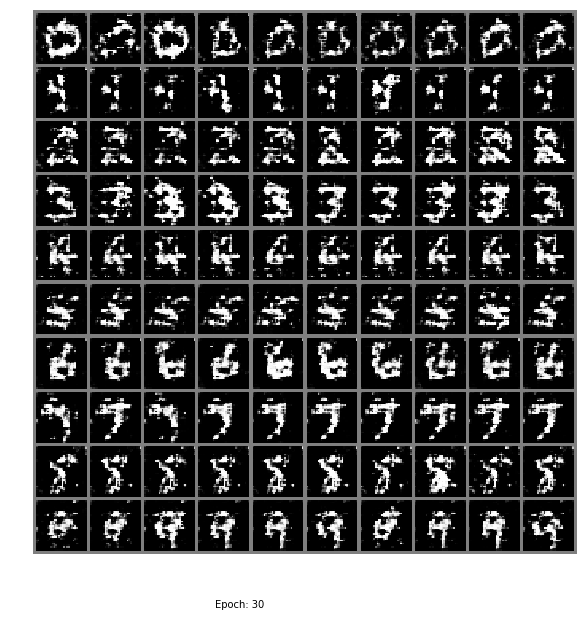

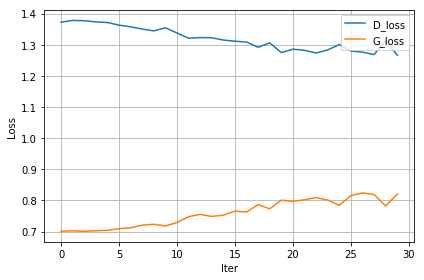

In [37]:
train_C(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/100] time: 11.91, loss_d: 1.374, loss_g: 0.706
Epoch : [2/100] time: 7.99, loss_d: 1.379, loss_g: 0.701
Epoch : [3/100] time: 7.98, loss_d: 1.378, loss_g: 0.701
Epoch : [4/100] time: 8.02, loss_d: 1.373, loss_g: 0.702
Epoch : [5/100] time: 8.03, loss_d: 1.366, loss_g: 0.708
Epoch : [6/100] time: 8.60, loss_d: 1.364, loss_g: 0.709
Epoch : [7/100] time: 8.26, loss_d: 1.358, loss_g: 0.713
Epoch : [8/100] time: 8.27, loss_d: 1.351, loss_g: 0.719
Epoch : [9/100] time: 8.26, loss_d: 1.353, loss_g: 0.720
Epoch : [10/100] time: 8.21, loss_d: 1.338, loss_g: 0.735
Epoch : [11/100] time: 8.19, loss_d: 1.323, loss_g: 0.746
Epoch : [12/100] time: 8.19, loss_d: 1.329, loss_g: 0.746
Epoch : [13/100] time: 8.19, loss_d: 1.326, loss_g: 0.747
Epoch : [14/100] time: 8.21, loss_d: 1.323, loss_g: 0.755
Epoch : [15/100] time: 8.19, loss_d: 1.336, loss_g: 0.741
Epoch : [16/100] time: 8.19, loss_d: 1.315, loss_g: 0.762
Epoch : [17/100] time: 8.19, loss_d: 1.309, loss_g: 0.771
Epoch : [18/100] time:

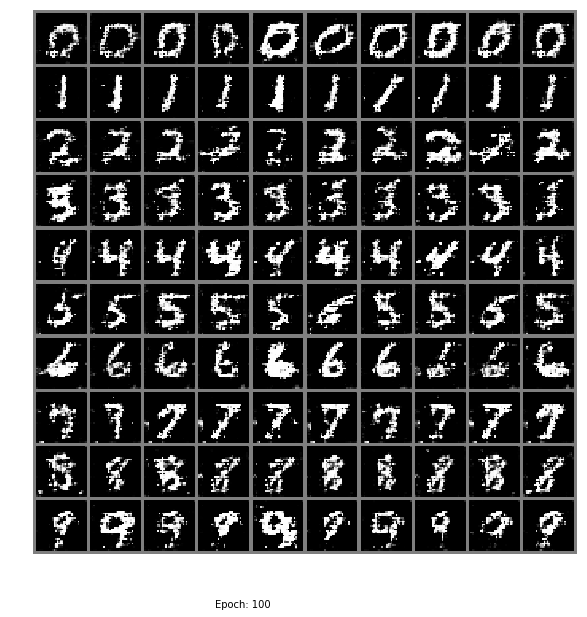

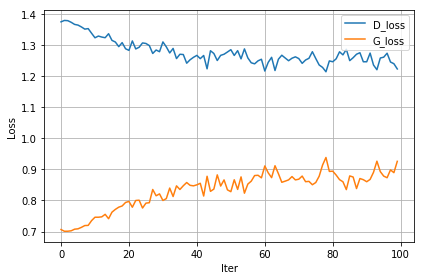

In [11]:
train_C(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

In [13]:
change_C()

Generator: Weights are different
Discriminator: Weights are different
Embedding: Weights are same


### SVHN Data

In [ ]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [24]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/30] time: 9.95, loss_d: 1.379, loss_g: 0.715
Epoch : [2/30] time: 9.81, loss_d: 1.354, loss_g: 0.707
Epoch : [3/30] time: 9.82, loss_d: 1.309, loss_g: 0.735
Epoch : [4/30] time: 9.82, loss_d: 1.245, loss_g: 0.782
Epoch : [5/30] time: 9.84, loss_d: 1.182, loss_g: 0.840
Epoch : [6/30] time: 9.84, loss_d: 1.118, loss_g: 0.897
Epoch : [7/30] time: 9.83, loss_d: 1.062, loss_g: 0.951
Epoch : [8/30] time: 9.83, loss_d: 1.014, loss_g: 1.005
Epoch : [9/30] time: 9.85, loss_d: 0.974, loss_g: 1.069
Epoch : [10/30] time: 9.90, loss_d: 0.924, loss_g: 1.120
Epoch : [11/30] time: 9.93, loss_d: 0.907, loss_g: 1.171
Epoch : [12/30] time: 10.23, loss_d: 0.852, loss_g: 1.239
Epoch : [13/30] time: 9.87, loss_d: 0.851, loss_g: 1.271
Epoch : [14/30] time: 9.92, loss_d: 0.846, loss_g: 1.290
Epoch : [15/30] time: 9.90, loss_d: 0.813, loss_g: 1.329
Epoch : [16/30] time: 9.90, loss_d: 0.810, loss_g: 1.357
Epoch : [17/30] time: 9.92, loss_d: 0.767, loss_g: 1.419
Epoch : [18/30] time: 9.92, loss_d: 0.8

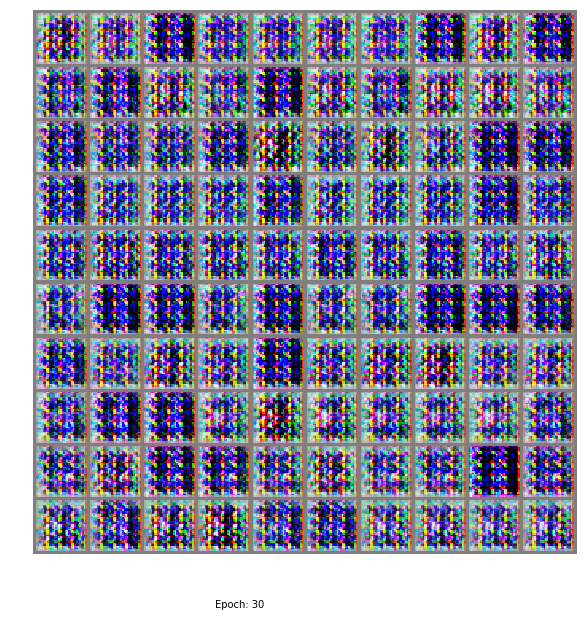

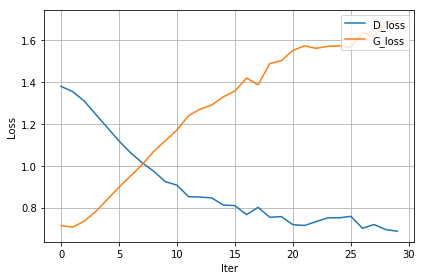

In [25]:
train_C(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

Epoch : [1/100] time: 10.02, loss_d: 1.379, loss_g: 0.689
Epoch : [2/100] time: 9.88, loss_d: 1.342, loss_g: 0.718
Epoch : [3/100] time: 9.86, loss_d: 1.272, loss_g: 0.769
Epoch : [4/100] time: 9.92, loss_d: 1.190, loss_g: 0.837
Epoch : [5/100] time: 9.93, loss_d: 1.121, loss_g: 0.910
Epoch : [6/100] time: 10.04, loss_d: 1.075, loss_g: 0.960
Epoch : [7/100] time: 10.13, loss_d: 1.026, loss_g: 1.015
Epoch : [8/100] time: 10.07, loss_d: 0.982, loss_g: 1.053
Epoch : [9/100] time: 10.05, loss_d: 0.932, loss_g: 1.127
Epoch : [10/100] time: 10.31, loss_d: 0.947, loss_g: 1.148
Epoch : [11/100] time: 10.01, loss_d: 0.878, loss_g: 1.205
Epoch : [12/100] time: 10.03, loss_d: 0.849, loss_g: 1.263
Epoch : [13/100] time: 10.01, loss_d: 0.841, loss_g: 1.289
Epoch : [14/100] time: 10.01, loss_d: 0.824, loss_g: 1.319
Epoch : [15/100] time: 9.99, loss_d: 0.784, loss_g: 1.375
Epoch : [16/100] time: 9.97, loss_d: 0.785, loss_g: 1.408
Epoch : [17/100] time: 10.01, loss_d: 0.766, loss_g: 1.444
Epoch : [18/

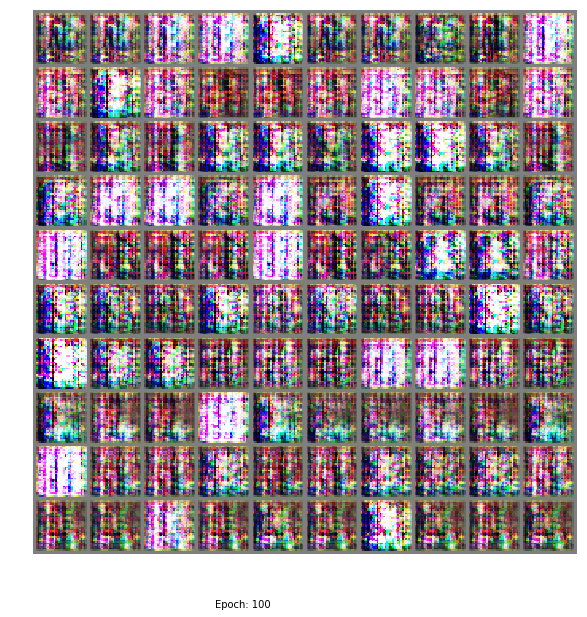

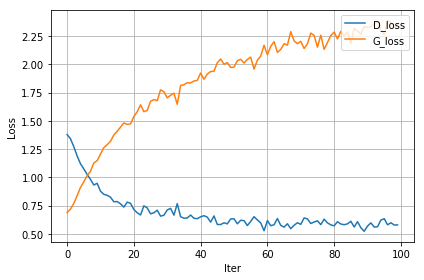

In [26]:
train_C(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

### Triplet Loss Initialized Embedding Layer E

In [27]:
# we will now be using LeNet instead of embeddingNet
from networks import LeNet, TripletNet

# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda = 1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = TripletNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'triplet'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

### MNIST 

In [ ]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [28]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [29]:
embeddingNet = model.embedding_net_1

Epoch : [1/20] time: 8.24, loss_d: 1.299, loss_g: 0.769
Epoch : [2/20] time: 8.12, loss_d: 1.278, loss_g: 0.781
Epoch : [3/20] time: 8.12, loss_d: 1.290, loss_g: 0.789
Epoch : [4/20] time: 8.57, loss_d: 1.298, loss_g: 0.783
Epoch : [5/20] time: 8.12, loss_d: 1.314, loss_g: 0.777
Epoch : [6/20] time: 8.11, loss_d: 1.317, loss_g: 0.772
Epoch : [7/20] time: 8.14, loss_d: 1.324, loss_g: 0.765
Epoch : [8/20] time: 8.26, loss_d: 1.318, loss_g: 0.770
Epoch : [9/20] time: 8.29, loss_d: 1.322, loss_g: 0.767
Epoch : [10/20] time: 8.30, loss_d: 1.319, loss_g: 0.773
Epoch : [11/20] time: 8.29, loss_d: 1.306, loss_g: 0.787
Epoch : [12/20] time: 8.29, loss_d: 1.302, loss_g: 0.789
Epoch : [13/20] time: 8.29, loss_d: 1.303, loss_g: 0.794
Epoch : [14/20] time: 8.27, loss_d: 1.306, loss_g: 0.796
Epoch : [15/20] time: 8.28, loss_d: 1.303, loss_g: 0.795
Epoch : [16/20] time: 8.29, loss_d: 1.268, loss_g: 0.831
Epoch : [17/20] time: 8.27, loss_d: 1.271, loss_g: 0.830
Epoch : [18/20] time: 8.68, loss_d: 1.28

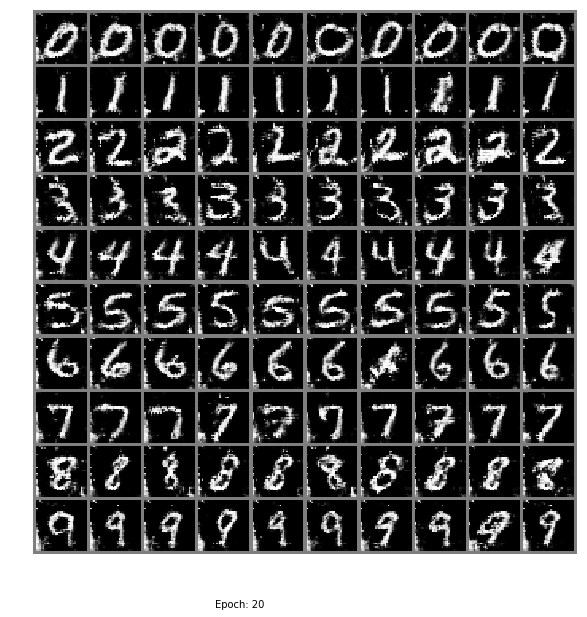

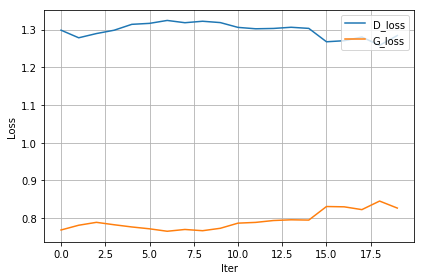

In [30]:
train_C(primaryTrainLoader, embeddingNet,  epochs=20, embeddingNetWt=0)

#### SVHN

In [ ]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [31]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

Epoch : [1/20] time: 10.02, loss_d: 1.374, loss_g: 0.706
Epoch : [2/20] time: 9.89, loss_d: 1.366, loss_g: 0.710
Epoch : [3/20] time: 9.89, loss_d: 1.341, loss_g: 0.728
Epoch : [4/20] time: 9.96, loss_d: 1.248, loss_g: 0.801
Epoch : [5/20] time: 10.12, loss_d: 1.106, loss_g: 0.928
Epoch : [6/20] time: 9.90, loss_d: 0.990, loss_g: 1.053
Epoch : [7/20] time: 9.93, loss_d: 0.942, loss_g: 1.135
Epoch : [8/20] time: 10.09, loss_d: 0.881, loss_g: 1.199
Epoch : [9/20] time: 10.33, loss_d: 0.827, loss_g: 1.310
Epoch : [10/20] time: 10.04, loss_d: 0.805, loss_g: 1.354
Epoch : [11/20] time: 10.06, loss_d: 0.627, loss_g: 1.469
Epoch : [12/20] time: 10.04, loss_d: 0.760, loss_g: 1.540
Epoch : [13/20] time: 10.06, loss_d: 0.589, loss_g: 1.725
Epoch : [14/20] time: 10.04, loss_d: 0.313, loss_g: 2.117
Epoch : [15/20] time: 10.05, loss_d: 0.568, loss_g: 1.856
Epoch : [16/20] time: 10.34, loss_d: 0.286, loss_g: 2.369
Epoch : [17/20] time: 10.02, loss_d: 0.572, loss_g: 2.047
Epoch : [18/20] time: 10.05,

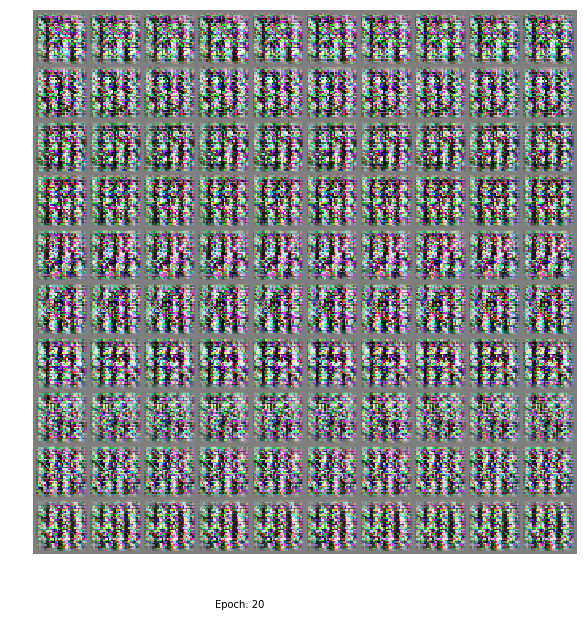

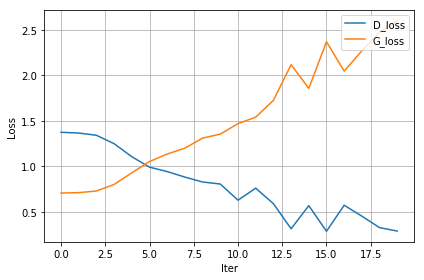

In [32]:
train_C(primaryTrainLoader, model.embedding_net_2,  epochs=20, embeddingNetWt=0)

### Contrastive Loss Initialized Embedding Layer E

In [54]:
# we will now be using LeNet instead of embeddingNet
from networks import LeNet, SiameseNet

# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda = 1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = SiameseNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'contrastive'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

### MNIST Dataset

In [ ]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [59]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [60]:
embeddingNet = model.embedding_net_1

Epoch : [1/20] time: 8.28, loss_d: 1.307, loss_g: 0.751
Epoch : [2/20] time: 8.18, loss_d: 1.267, loss_g: 0.799
Epoch : [3/20] time: 8.16, loss_d: 1.374, loss_g: 0.712
Epoch : [4/20] time: 8.13, loss_d: 1.375, loss_g: 0.707
Epoch : [5/20] time: 8.98, loss_d: 1.374, loss_g: 0.706
Epoch : [6/20] time: 8.17, loss_d: 1.371, loss_g: 0.709
Epoch : [7/20] time: 8.19, loss_d: 1.367, loss_g: 0.711
Epoch : [8/20] time: 8.16, loss_d: 1.141, loss_g: 0.892
Epoch : [9/20] time: 8.24, loss_d: 0.644, loss_g: 1.442
Epoch : [10/20] time: 8.21, loss_d: 0.392, loss_g: 1.953
Epoch : [11/20] time: 8.16, loss_d: 0.240, loss_g: 2.390
Epoch : [12/20] time: 8.28, loss_d: 0.202, loss_g: 2.688
Epoch : [13/20] time: 8.30, loss_d: 0.438, loss_g: 2.236
Epoch : [14/20] time: 8.26, loss_d: 0.487, loss_g: 2.178
Epoch : [15/20] time: 8.29, loss_d: 0.421, loss_g: 2.295
Epoch : [16/20] time: 8.30, loss_d: 0.398, loss_g: 2.507
Epoch : [17/20] time: 8.25, loss_d: 0.377, loss_g: 2.551
Epoch : [18/20] time: 8.30, loss_d: 0.20

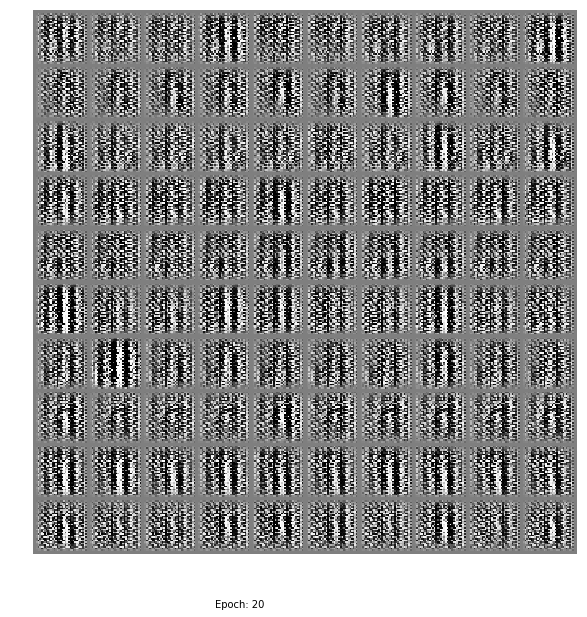

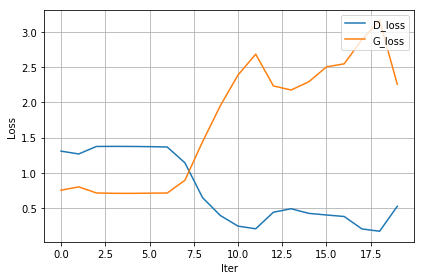

In [61]:
train_C(primaryTrainLoader, embeddingNet,  epochs=20, embeddingNetWt=0)

### SVHN Dataset

In [ ]:
from model_exp0a_c import Generator, Discriminator, EmbeddingNet

In [62]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [63]:
embeddingNet = model.embedding_net_2

Epoch : [1/20] time: 10.13, loss_d: 1.381, loss_g: 0.698
Epoch : [2/20] time: 9.96, loss_d: 1.351, loss_g: 0.711
Epoch : [3/20] time: 10.34, loss_d: 1.289, loss_g: 0.755
Epoch : [4/20] time: 9.93, loss_d: 1.217, loss_g: 0.813
Epoch : [5/20] time: 9.93, loss_d: 1.137, loss_g: 0.882
Epoch : [6/20] time: 9.98, loss_d: 1.065, loss_g: 0.956
Epoch : [7/20] time: 10.00, loss_d: 0.955, loss_g: 1.066
Epoch : [8/20] time: 9.96, loss_d: 0.944, loss_g: 1.112
Epoch : [9/20] time: 10.07, loss_d: 0.890, loss_g: 1.173
Epoch : [10/20] time: 10.14, loss_d: 0.877, loss_g: 1.214
Epoch : [11/20] time: 10.04, loss_d: 0.835, loss_g: 1.277
Epoch : [12/20] time: 10.05, loss_d: 0.820, loss_g: 1.320
Epoch : [13/20] time: 10.08, loss_d: 0.794, loss_g: 1.364
Epoch : [14/20] time: 10.08, loss_d: 0.783, loss_g: 1.402
Epoch : [15/20] time: 10.54, loss_d: 0.789, loss_g: 1.423
Epoch : [16/20] time: 10.03, loss_d: 0.748, loss_g: 1.473
Epoch : [17/20] time: 10.08, loss_d: 0.785, loss_g: 1.433
Epoch : [18/20] time: 10.10,

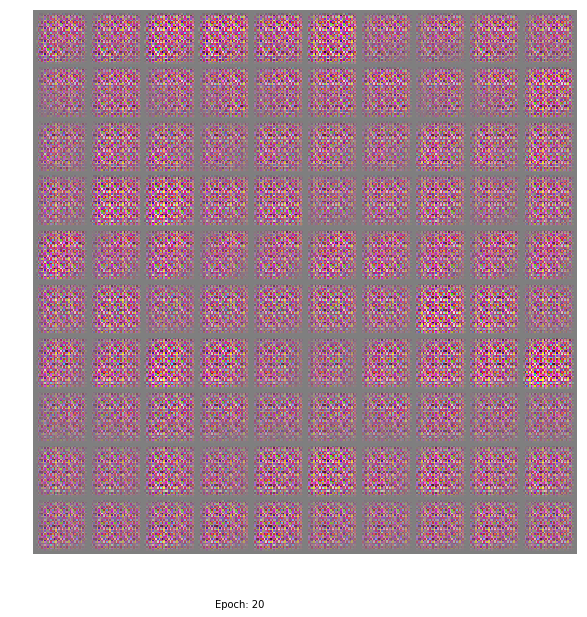

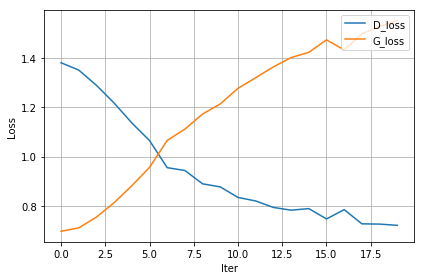

In [64]:
train_C(primaryTrainLoader, embeddingNet,  epochs=20, embeddingNetWt=0)